In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Data load
df = pd.read_csv('/content/drive/MyDrive/bs.csv', encoding='cp949', index_col=0)
df = df.dropna()
x = df.iloc[:,1:]
y = df.iloc[:,:1]

In [4]:
# Training/Test ratio = 7:3
Train_ratio = 0.7
Test_ratio = 0.3

# Data Division
train_x = x.iloc[0:int(len(df)*Train_ratio),:]
train_y = y.iloc[0:int(len(df)*Train_ratio),:]
test_x = x.iloc[int(len(df)*Train_ratio):,:]
test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [5]:
# Normalizing
minmax_x = MinMaxScaler()
minmax_y = MinMaxScaler()

train_x = minmax_x.fit_transform(train_x)
train_y = minmax_y.fit_transform(train_y)
test_x = minmax_x.fit_transform(test_x)
test_y = minmax_y.fit_transform(test_y)

# Check Data pre-processing
print("Training shape : ", train_x.shape, train_y.shape)
print("Test shape : ",test_x.shape, test_y.shape)

Training shape :  (79, 10) (79, 1)
Test shape :  (34, 10) (34, 1)


In [6]:
# Torch Variable 형태로 변경(data/grad/grad_fn)
train_x_tensor = Variable(torch.Tensor(train_x))
train_y_tensor = Variable(torch.Tensor(train_y))
test_x_tensor = Variable(torch.Tensor(test_x))
test_y_tensor = Variable(torch.Tensor(test_y))

print("After torch variable shape_Train : ",train_x_tensor.shape, train_y.shape)
print("After torch Variable shape_Test : ",test_x_tensor.shape, test_y_tensor.shape)

After torch variable shape_Train :  torch.Size([79, 10]) (79, 1)
After torch Variable shape_Test :  torch.Size([34, 10]) torch.Size([34, 1])


In [7]:
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))
test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))
test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

print(train_x_tensor_final.shape, test_x_tensor_final.shape)

torch.Size([79, 1, 10]) torch.Size([34, 1, 10])


In [8]:
# Check GPU setting
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

Tesla T4


In [10]:
# LSTM definition
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = train_x_tensor_final.shape[2]
hidden_size = 128
num_layers = 2
output_size = 1

model = LSTM_Model(input_size, hidden_size, num_layers, output_size)

In [22]:
# LSTM training
num_epochs = 500
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_x_tensor_final)
    optimizer.zero_grad()
    loss = criterion(outputs, torch.reshape(train_y_tensor_final, (train_y_tensor_final.shape[0], train_y_tensor_final.shape[1])))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/500], Loss: 0.0062
Epoch [11/500], Loss: 0.0065
Epoch [21/500], Loss: 0.0062
Epoch [31/500], Loss: 0.0062
Epoch [41/500], Loss: 0.0062
Epoch [51/500], Loss: 0.0062
Epoch [61/500], Loss: 0.0061
Epoch [71/500], Loss: 0.0061
Epoch [81/500], Loss: 0.0061
Epoch [91/500], Loss: 0.0061
Epoch [101/500], Loss: 0.0061
Epoch [111/500], Loss: 0.0060
Epoch [121/500], Loss: 0.0060
Epoch [131/500], Loss: 0.0060
Epoch [141/500], Loss: 0.0060
Epoch [151/500], Loss: 0.0059
Epoch [161/500], Loss: 0.0059
Epoch [171/500], Loss: 0.0058
Epoch [181/500], Loss: 0.0058
Epoch [191/500], Loss: 0.0058
Epoch [201/500], Loss: 0.0057
Epoch [211/500], Loss: 0.0056
Epoch [221/500], Loss: 0.0056
Epoch [231/500], Loss: 0.0055
Epoch [241/500], Loss: 0.0055
Epoch [251/500], Loss: 0.0054
Epoch [261/500], Loss: 0.0054
Epoch [271/500], Loss: 0.0053
Epoch [281/500], Loss: 0.0052
Epoch [291/500], Loss: 0.0052
Epoch [301/500], Loss: 0.0051
Epoch [311/500], Loss: 0.0051
Epoch [321/500], Loss: 0.0050
Epoch [331/500], Loss

In [14]:
# LSTM evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(test_x_tensor_final)
    test_loss = criterion(test_outputs, torch.reshape(test_y_tensor_final, (test_y_tensor_final.shape[0], test_y_tensor_final.shape[1])))
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0190


In [15]:
# prediction
predicted = np.concatenate((minmax_x.inverse_transform(test_x), minmax_y.inverse_transform(test_outputs.numpy())), axis=1)[:, -1]
actual = np.concatenate((minmax_x.inverse_transform(test_x), minmax_y.inverse_transform(test_y.reshape(-1, 1))), axis=1)[:, -1]

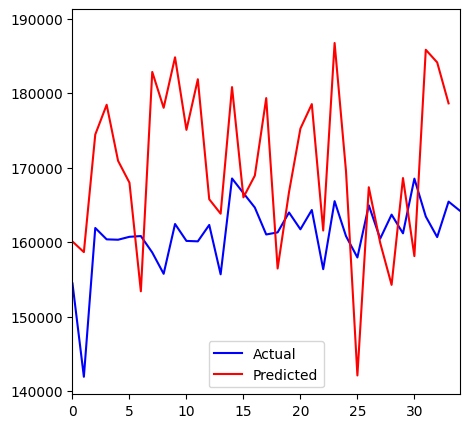

In [17]:
plt.figure(figsize=(5,5))

# Actual graph
actual_data = np.concatenate((minmax_x.inverse_transform(train_x_tensor_final.view(-1, input_size).cpu().numpy()), minmax_y.inverse_transform(train_y_tensor_final.view(-1, 1).cpu().numpy())), axis=1)
mean_actual = actual_data.mean(axis=1)

plt.plot(mean_actual, label='Actual', color='blue')

# Predicted graph
predicted_data = np.concatenate((minmax_x.inverse_transform(test_x_tensor_final.view(-1, input_size).cpu().numpy()), minmax_y.inverse_transform(test_outputs.view(-1, 1).cpu().numpy())), axis=1)
mean_predicted = predicted_data.mean(axis=1)

plt.plot(mean_predicted, label='Predicted', color='red')
plt.xlim(0, len(mean_predicted))

plt.legend()
plt.show()

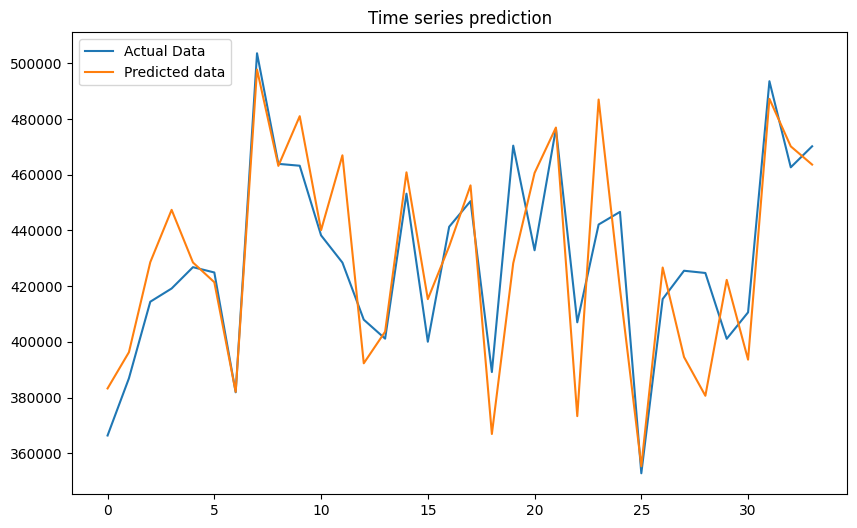

In [18]:
#Figure
plt.figure(figsize = (10,6)) # Plotting
plt.plot(actual, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

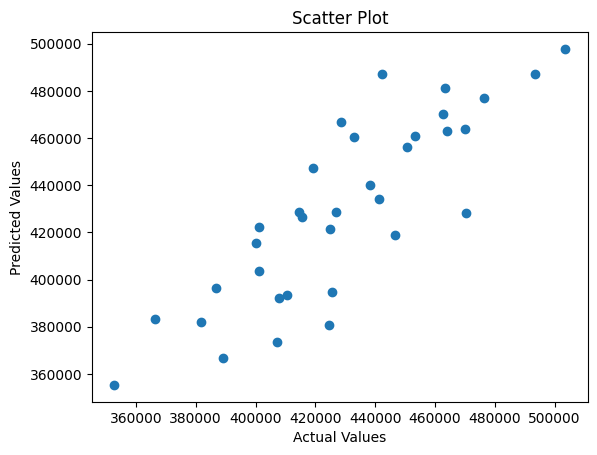

In [19]:
# 산포도 그래프 (Scatter Plot)
plt.scatter(actual, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot")
plt.show()

In [30]:
import copy
data_combined_x = np.concatenate((train_x, test_x), axis=0)
data_combined_y = np.concatenate((train_y, test_y), axis=0)
PlotEstimated = np.empty_like(np.concatenate((data_combined_x, data_combined_y), axis=1))
PlotEstimated[:, :] = np.nan

In [28]:
result = predicted.reshape(34,1)

In [29]:
#PlotEstimated의 복사본
# trainPlotEstimated = copy.deepcopy(PlotEstimated)
# trainPlotEstimated[self.m_window_step:len(self.m_TrainEstimated)+self.m_window_step, :] = self.m_TrainEstimated
testPlotEstimated = copy.deepcopy(PlotEstimated)
testPlotEstimated[79:, -1:] = result

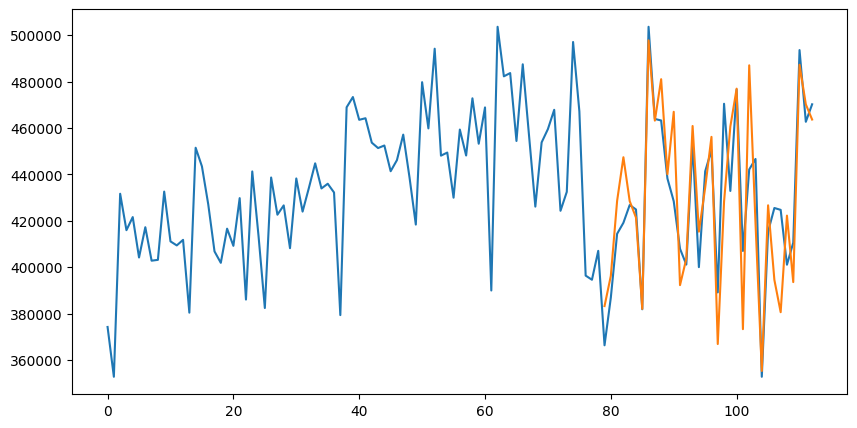

In [37]:
plt.figure(figsize=(10,5))

#실제 데이터, 학습데이터, 테스트 데이터의 예측값 그래프로
plt.plot(minmax_y.inverse_transform(data_combined_y))
# plt.plot(trainPlotEstimated)
plt.plot(testPlotEstimated)
plt.show()